
# Randomized Response (Bayesian) with Unknown `p_forced`
**Goal:** Estimate the true prevalence $\theta$ of smoking among youths using a randomized response design where the probability of a forced "YES" ($p_{\text{forced}}$) is *unknown* and estimated from the data with a prior.

**Design**
- Flip a coin per respondent.
- If **Heads** (앞면): must answer **YES** (forced YES).
- If **Tails** (뒷면): answer **truthfully**.

**Observed:** $N=100$, YES=80, NO=20.  
**Model:** Let the true prevalence be $\theta$. The observed probability of saying YES is
\[ q = p_{\text{forced}} + (1 - p_{\text{forced}})\,\theta. \]
We use priors $\theta \sim \text{Beta}(\alpha,\beta)$ and $p_{\text{forced}} \sim \text{Beta}(a_{\text{forced}}, b_{\text{forced}})$.

This notebook will:
1. Compile & sample a Stan model via **cmdstanpy** *(if CmdStan is available)*.
2. Otherwise, perform a **grid-based Bayesian inference** as a fallback.
3. Summarize posteriors and plot figures for $\theta$, $p_{\text{forced}}$, joint posterior, and posterior predictive.



## 0. (Optional) Environment Setup
- Install `cmdstanpy` if needed.
- Optionally install CmdStan (first time only). If CmdStan is already installed, set your `CMDSTAN` env var to that path.


In [7]:

# If needed, uncomment:
# !pip install cmdstanpy

# Optional one-time CmdStan install (can take several minutes):
# from cmdstanpy import install_cmdstan
# install_cmdstan()



## 1. Data & Priors
Edit values below to fit your study.


In [8]:

# Data
N = 100
y_yes = 80

# Priors
alpha = 1.0   # theta ~ Beta(alpha, beta)
beta  = 1.0
a_forced = 20.0  # p_forced ~ Beta(a_forced, b_forced) (moderately informative near 0.5)
b_forced = 20.0

print({"N": N, "y_yes": y_yes, "alpha": alpha, "beta": beta, "a_forced": a_forced, "b_forced": b_forced})


{'N': 100, 'y_yes': 80, 'alpha': 1.0, 'beta': 1.0, 'a_forced': 20.0, 'b_forced': 20.0}



## 2. Stan Model (Unknown `p_forced`)
We model both $\theta$ and $p_{\text{forced}}$ as parameters with Beta priors.


In [9]:

stan_code = '''
data {
  int<lower=0> N;                 // total respondents
  int<lower=0, upper=N> y_yes;    // observed YES count

  // Prior for theta (true prevalence)
  real<lower=0> alpha;
  real<lower=0> beta;

  // Prior for p_forced (forced-YES probability)
  real<lower=0> a_forced;
  real<lower=0> b_forced;
}

parameters {
  real<lower=0, upper=1> theta;      // true smoking prevalence
  real<lower=0, upper=1> p_forced;   // forced-YES probability (unknown)
}

transformed parameters {
  real<lower=0, upper=1> q;          // Pr(YES observed)
  q = p_forced + (1.0 - p_forced) * theta;
}

model {
  // Priors
  theta    ~ beta(alpha, beta);
  p_forced ~ beta(a_forced, b_forced);

  // Likelihood
  y_yes ~ binomial(N, q);
}

generated quantities {
  // Posterior predictive replicate
  int y_rep = binomial_rng(N, q);

  // Invert q -> theta via algebra (for diagnostics)
  real<lower=0, upper=1> theta_via_q;
  theta_via_q = fmin(fmax((q - p_forced) / (1.0 - p_forced), 0), 1);
}
'''
with open("stan_model_unknown_p.stan", "w") as f:
    f.write(stan_code)
print("Wrote stan_model_unknown_p.stan")


Wrote stan_model_unknown_p.stan



## 3. Try Stan + CmdStanPy Sampling
If Stan isn't available, this cell will raise an error; in that case, skip to Section 4 (grid-based posterior).


In [10]:

use_stan = True
post_draws = None
fit_summary = None

try:
    from cmdstanpy import CmdStanModel
    model = CmdStanModel(stan_file="stan_model_unknown_p.stan")

    data = {
        "N": N,
        "y_yes": y_yes,
        "alpha": alpha,
        "beta": beta,
        "a_forced": a_forced,
        "b_forced": b_forced,
    }

    fit = model.sample(
        data=data,
        chains=4,
        parallel_chains=4,
        iter_warmup=1000,
        iter_sampling=1000,
        adapt_delta=0.9,
        seed=20251009,
    )

    print(fit.diagnose())
    fit_summary = fit.summary()
    display(fit_summary)

    import numpy as np
    import pandas as pd
    theta = fit.stan_variable("theta")
    p_forced_draws = fit.stan_variable("p_forced")
    q = fit.stan_variable("q")
    y_rep = fit.stan_variable("y_rep")

    post_draws = pd.DataFrame({
        "theta": theta,
        "p_forced": p_forced_draws,
        "q": q,
        "y_rep": y_rep
    })
    post_draws.to_csv("cmdstanpy_posterior_draws.csv", index=False)
    print("Saved MCMC draws -> cmdstanpy_posterior_draws.csv")

except Exception as e:
    use_stan = False
    print("Stan/cmdstanpy sampling not available here. Reason:", e)


01:05:44 - cmdstanpy - INFO - compiling stan file /Users/yndk/Desktop/KOS6002/RRT/stan_model_unknown_p.stan to exe file /Users/yndk/Desktop/KOS6002/RRT/stan_model_unknown_p
01:05:47 - cmdstanpy - INFO - compiled model executable: /Users/yndk/Desktop/KOS6002/RRT/stan_model_unknown_p
01:05:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:05:47 - cmdstanpy - INFO - CmdStan done processing.



Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-80.235400,0.030612,1.081690,0.730185,-82.410000,-79.875700,-79.238600,1591.90,1778.64,46820.5,1.00121
theta,0.569536,0.002922,0.111901,0.100026,0.366527,0.582522,0.725528,1709.04,1343.54,50265.9,1.00368
p_forced,0.509960,0.002093,0.079406,0.078703,0.376227,0.510652,0.641942,1436.37,1529.82,42246.1,1.00431
q,0.794803,0.000750,0.039022,0.038398,0.726376,0.797255,0.856022,2776.73,2788.29,81668.6,1.00079
y_rep,79.519000,0.099321,5.550120,5.930400,70.000000,80.000000,88.000000,3133.40,3267.23,92158.8,1.00062
theta_via_q,0.569536,0.002922,0.111901,0.100026,0.366527,0.582522,0.725528,1709.04,1343.54,50265.9,1.00368


Saved MCMC draws -> cmdstanpy_posterior_draws.csv



## 4. Grid-based Posterior (Fallback if Stan not available)
This computes an approximate joint posterior on a grid for $(\theta, p_{\text{forced}})$.


In [11]:

import numpy as np
import pandas as pd

if post_draws is None:
    # Grid resolution
    G = 400
    theta_grid = np.linspace(1e-4, 1 - 1e-4, G)
    p_grid = np.linspace(1e-4, 1 - 1e-4, G)

    TT, PP = np.meshgrid(theta_grid, p_grid, indexing='xy')
    QQ = PP + (1.0 - PP) * TT

    def log_beta_pdf(x, a, b):
        return (a - 1) * np.log(x) + (b - 1) * np.log(1 - x)

    loglik = y_yes * np.log(QQ) + (N - y_yes) * np.log(1 - QQ)
    logprior_theta = log_beta_pdf(TT, alpha, beta)
    logprior_p = log_beta_pdf(PP, a_forced, b_forced)

    logpost = loglik + logprior_theta + logprior_p
    logpost -= np.max(logpost)
    post = np.exp(logpost)
    post /= post.sum()

    # Draw posterior samples from grid
    num_samp = 50000
    flat = post.ravel(order="C")
    idx = np.random.choice(flat.size, size=num_samp, p=flat)
    rows = idx // G
    cols = idx % G
    th_s = theta_grid[cols]
    pf_s = p_grid[rows]
    q_s = pf_s + (1 - pf_s) * th_s
    yrep_s = np.random.binomial(N, q_s)

    post_draws = pd.DataFrame({
        "theta": th_s,
        "p_forced": pf_s,
        "q": q_s,
        "y_rep": yrep_s
    })
    post_draws.to_csv("grid_posterior_draws.csv", index=False)
    print("Saved grid posterior draws -> grid_posterior_draws.csv")

# Show quick summaries
def ci(x, level=0.95):
    lo = (1 - level) / 2
    hi = 1 - lo
    return np.quantile(x, lo), np.quantile(x, hi)

theta_mean = float(post_draws["theta"].mean())
theta_lo, theta_hi = ci(post_draws["theta"])
p_mean = float(post_draws["p_forced"].mean())
p_lo, p_hi = ci(post_draws["p_forced"])
q_mean = float(post_draws["q"].mean())
print(f"theta mean: {theta_mean:.3f}, 95% CrI: [{theta_lo:.3f}, {theta_hi:.3f}]")
print(f"p_forced mean: {p_mean:.3f}, 95% CrI: [{p_lo:.3f}, {p_hi:.3f}]")
print(f"q mean: {q_mean:.3f}")


theta mean: 0.570, 95% CrI: [0.303, 0.748]
p_forced mean: 0.510, 95% CrI: [0.354, 0.665]
q mean: 0.795



## 5. Plots
We visualize:
1. Posterior of $\theta$  
2. Posterior of $p_{\text{forced}}$  
3. Joint posterior samples (scatter)  
4. Posterior predictive $Y_{\text{rep}}$


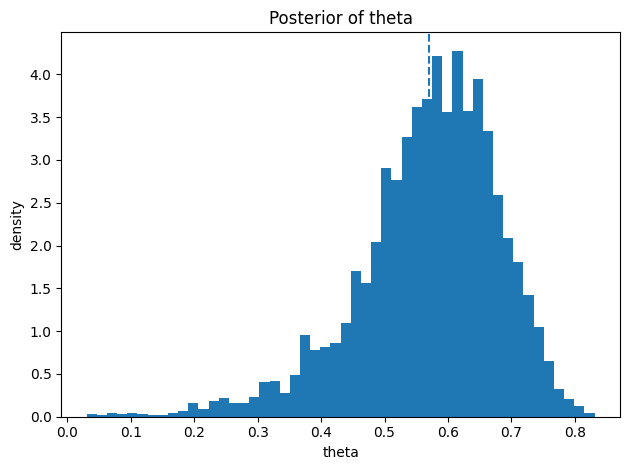

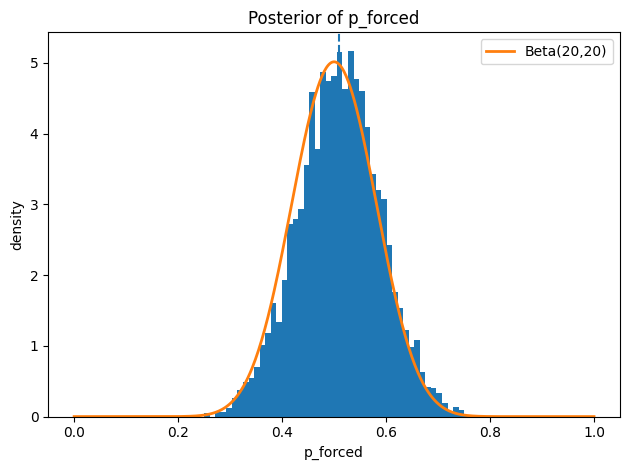

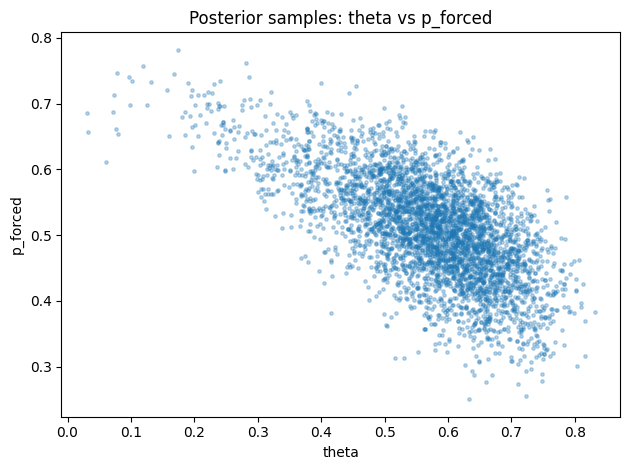

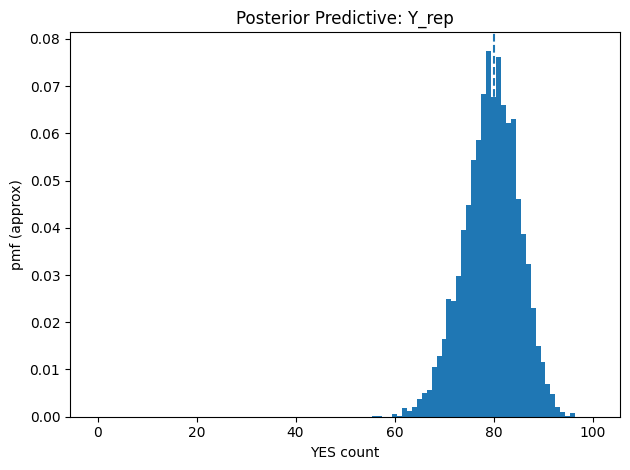

In [20]:

import matplotlib.pyplot as plt
import numpy as np
import math

# 1) theta posterior
plt.figure()
plt.hist(post_draws["theta"], bins=50, density=True)
plt.axvline(post_draws["theta"].mean(), linestyle='--')
plt.title("Posterior of theta")
plt.xlabel("theta"); plt.ylabel("density")
plt.tight_layout()
plt.show()

# 2) p_forced posterior
plt.figure()
plt.hist(post_draws["p_forced"], bins=50, density=True)
plt.axvline(post_draws["p_forced"].mean(), linestyle='--')
plt.title("Posterior of p_forced")
plt.xlabel("p_forced"); plt.ylabel("density")

x = np.linspace(1e-4, 1 - 1e-4, 500)
B = math.gamma(a_forced) * math.gamma(b_forced) / math.gamma(a_forced + b_forced)
pdf = x**(a_forced - 1) * (1 - x)**(b_forced - 1) / B
plt.plot(x, pdf, color='C1', lw=2, label=f'Beta({int(a_forced)},{int(b_forced)})')
plt.legend()

plt.tight_layout()
plt.show()

# 3) joint scatter (thin for display)
plt.figure()
idx = np.random.choice(len(post_draws), size=min(5000, len(post_draws)), replace=False)
plt.scatter(post_draws["theta"].iloc[idx], post_draws["p_forced"].iloc[idx], s=6, alpha=0.3)
plt.title("Posterior samples: theta vs p_forced")
plt.xlabel("theta"); plt.ylabel("p_forced")
plt.tight_layout()
plt.show()

# 4) posterior predictive
plt.figure()
plt.hist(post_draws["y_rep"], bins=range(0, int(max(post_draws["y_rep"].max(), 100))+2), align='left', density=True)
plt.axvline(y_yes, linestyle='--')
plt.title("Posterior Predictive: Y_rep")
plt.xlabel("YES count"); plt.ylabel("pmf (approx)")
plt.tight_layout()
plt.show()



## 6. Interpretation Notes
- The data imply $q \approx 0.8$. With $p_{\text{forced}}$ centered near 0.5, the posterior for $\theta$ is near $(0.8-0.5)/0.5 = 0.6$.
- Expect **negative correlation** between $\theta$ and $p_{\text{forced}}$: higher forced-YES probability implies a slightly smaller prevalence and vice versa.
- If you *know* the randomizer was very close to fair, use a tighter prior (e.g., Beta(40,40)) to reduce posterior uncertainty.


# Why $\theta$ and $p_{\text{forced}}$ Are Negatively Correlated

The key model equation is:

$$
q = p_{\text{forced}} + (1 - p_{\text{forced}})\,\theta
$$

where  
- $q$: observed probability of answering “YES” (≈ 0.8 in the data)  
- $p_{\text{forced}}$: probability of being forced to say “YES”  
- $\theta$: true smoking prevalence among youths  

---

## 1. One Equation, Two Unknowns

Only $q$ is directly observed.  
That means many pairs $(\theta, p_{\text{forced}})$ can produce the same $q$:

$$
0.8 = p_{\text{forced}} + (1 - p_{\text{forced}})\,\theta
$$
$$
\Rightarrow \theta = \frac{0.8 - p_{\text{forced}}}{1 - p_{\text{forced}}}
$$

This is a **line with a negative slope** in the $(p_{\text{forced}}, \theta)$ plane.  
If $p_{\text{forced}}$ increases, $\theta$ must decrease to keep $q$ constant.

That’s why their posterior samples are negatively correlated.

---

## 2. Intuitive Interpretation

- If the randomizer often forces “YES” (large $p_{\text{forced}}$),  
  fewer YES answers are genuine, so the true smoking rate $\theta$ must be **smaller**.
- If the randomizer rarely forces “YES” (small $p_{\text{forced}}$),  
  most YES answers come from actual smokers, so $\theta$ must be **larger**.

Thus, the posterior lies along a **downward ridge** in the $(\theta, p_{\text{forced}})$ plane.

---

## 3. Bayesian / Geometric View

- The **likelihood** depends only on $q$, not on $\theta$ and $p_{\text{forced}}$ separately.  
  → Creates a *ridge* of equally likely parameter combinations.

- The **priors** (e.g., $p_{\text{forced}}\sim \text{Beta}(20,20)$) restrict the ridge around $p_{\text{forced}}\approx 0.5$.

- The **posterior** becomes an **elongated, negatively sloped region**—hence the negative correlation in the joint posterior scatter plot.

---

## 4. Mathematical Derivation

Differentiate $\theta$ with respect to $p_{\text{forced}}$ while holding $q$ fixed:

$$
\frac{d\theta}{dp_{\text{forced}}} =
\frac{-1(1 - p_{\text{forced}}) - (q - p_{\text{forced}})}{(1 - p_{\text{forced}})^2}
= \frac{q - 1}{(1 - p_{\text{forced}})^2} < 0
$$

Since $q < 1$, the derivative is **negative**, proving the inverse relationship.

---

## ✅ Summary

| Concept | Explanation |
|----------|--------------|
| Functional link | $q = p_f + (1-p_f)\theta$ implies a trade-off between the two |
| Geometry | Constant-$q$ lines slope downward in $(\theta, p_f)$ space |
| Interpretation | More forced “YES” → fewer true smokers needed |
| Posterior shape | Long, downward-sloping ridge → negative correlation |

Hence, **$\theta$ and $p_{\text{forced}}$ are negatively correlated** because both compete to explain the same observed probability $q$.
